In [ ]:
!git clone https://github.com/bakhbyergyen7/FinalProject.git
%cd FinalProject/project_1_dataset
!ls

Cloning into 'FinalProject'...
remote: Enumerating objects: 27793, done.
remote: Counting objects: 100% (309/309), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 27793 (delta 173), reused 297 (delta 161), pack-reused 27484
Receiving objects: 100% (27793/27793), 47.26 MiB | 24.33 MiB/s, done.
Resolving deltas: 100% (177/177), done.
Updating files: 100% (28320/28320), done.
/content/FinalProject/project_1_dataset
test  train


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Set up data generators
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     validation_split=0.2  # Reserve 20% of the data for test
# )

# test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for testing

In [ ]:
# Define the directory for training data
train_directory = 'train'
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Lambda, Input
import tensorflow as tf

# Load the training and validation data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    validation_split=0.2,  # Reserve 20% for validation
    subset="training",
    seed=123,  # Seed for reproducibility
    image_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',  # Images are grayscale
    label_mode='categorical'  # Labels are categorical
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    validation_split=0.2, # Reserve 20% for validation
    subset="validation",
    seed=123, # Seed for reproducibility
    image_size=(48, 48),
    batch_size=64,
    color_mode='grayscale', # Images are grayscale
    label_mode='categorical' # Labels are categorical
)


test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    image_size=(48, 48),
    batch_size=64,
    color_mode='grayscale', # Images are grayscale
    label_mode='categorical' # Labels are categorical
)

Found 20634 files belonging to 7 classes.
Using 16508 files for training.
Found 20634 files belonging to 7 classes.
Using 4126 files for validation.
Found 5155 files belonging to 7 classes.


In [ ]:
# Define model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

# Set up the ModelCheckpoint callback to save the best model based on the validation accuracy
model_checkpoint_callback = ModelCheckpoint(
    'best_model.keras',  # Path where the model will be saved
    save_best_only=True,  # Save only the best model
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',  # Save the model with max validation accuracy
    verbose=1
)

# Set up the EarlyStopping callback to stop training if no improvement in validation accuracy
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=8,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

# Set up the ReduceLROnPlateau callback to reduce the learning rate when the validation accuracy plateaus
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.9,  # New learning rate will be lr * factor.
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=0.00001,  # Lower bound on the learning rate.
    verbose=1
)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train model
history = model.fit(
    train_data,
    epochs=50,
    validation_data=validation_data,  # Use the validation data generator here
    callbacks=[
        model_checkpoint_callback,
        early_stopping_callback,
        reduce_lr_callback
    ]
)

Epoch 1/50
258/258 [==============================] - ETA: 0s - loss: 2.2548 - accuracy: 0.2427
Epoch 1: val_accuracy improved from -inf to 0.39433, saving model to best_model.keras
258/258 [==============================] - 15s 24ms/step - loss: 2.2548 - accuracy: 0.2427 - val_loss: 1.6593 - val_accuracy: 0.3943 - lr: 1.0000e-04
Epoch 2/50
256/258 [============================>.] - ETA: 0s - loss: 1.9558 - accuracy: 0.3362
Epoch 2: val_accuracy improved from 0.39433 to 0.44304, saving model to best_model.keras
258/258 [==============================] - 5s 19ms/step - loss: 1.9575 - accuracy: 0.3357 - val_loss: 1.5235 - val_accuracy: 0.4430 - lr: 1.0000e-04
Epoch 3/50
256/258 [============================>.] - ETA: 0s - loss: 1.7962 - accuracy: 0.3752
Epoch 3: val_accuracy improved from 0.44304 to 0.45371, saving model to best_model.keras
258/258 [==============================] - 5s 18ms/step - loss: 1.7967 - accuracy: 0.3749 - val_loss: 1.4623 - val_accuracy: 0.4537 - lr: 1.0000e-04


In [ ]:
# Evaluate the model on the test data
evaluation = model.evaluate(test_data)
print("Test Loss:", evaluation[0], "Test Accuracy:", evaluation[1])

81/81 [==============================] - 1s 11ms/step - loss: 1.1997 - accuracy: 0.5738
Test Loss: 1.199652910232544 Test Accuracy: 0.5738118290901184


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory("test",
                                                    target_size=(48, 48),
                                                    color_mode="grayscale",
                                                    batch_size=64,
                                                    seed=7,
                                                    shuffle=False,
                                                    class_mode="categorical"
                                                    )

import os
class_names = [item for item in os.listdir("test") if os.path.isdir(os.path.join("test", item))]
nb_test_samples = test_generator.samples
nb_classes = len(class_names)
print(nb_test_samples)
print(nb_classes)

Found 5155 images belonging to 7 classes.
5155
7


In [ ]:
output = model.predict(test_generator)
y_classes = output.argmax(axis=1)
result = sum(y_classes==test_generator.classes)/nb_test_samples*100
print(result)

81/81 [==============================] - 2s 27ms/step
14.374393792434528


In [ ]:
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

81/81 [==============================] - 2s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report for Custom CNN:
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00       727
     disgust       0.00      0.00      0.00        78
        fear       0.00      0.00      0.00       721
       happy       0.00      0.00      0.00      1348
     neutral       0.00      0.00      0.00       962
         sad       0.14      1.00      0.25       741
    surprise       0.00      0.00      0.00       578

    accuracy                           0.14      5155
   macro avg       0.02      0.14      0.04      5155
weighted avg       0.02      0.14      0.04      5155



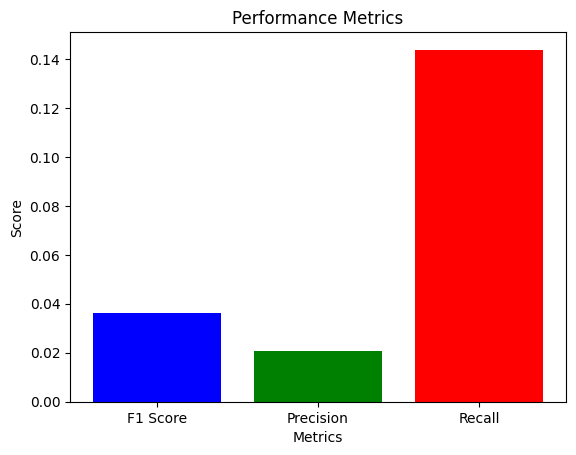

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
# Classification report
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report for Custom CNN:\n", classification_report(test_generator.classes, y_classes, target_names=class_labels))

f1 = f1_score(test_generator.classes, y_classes, average='weighted')
precision = precision_score(test_generator.classes,y_classes, average='weighted')
recall = recall_score(test_generator.classes, y_classes, average='weighted')

labels = ['F1 Score', 'Precision', 'Recall']
scores = [f1, precision, recall]

plt.bar(labels, scores, color=['blue', 'green', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics')
plt.show()

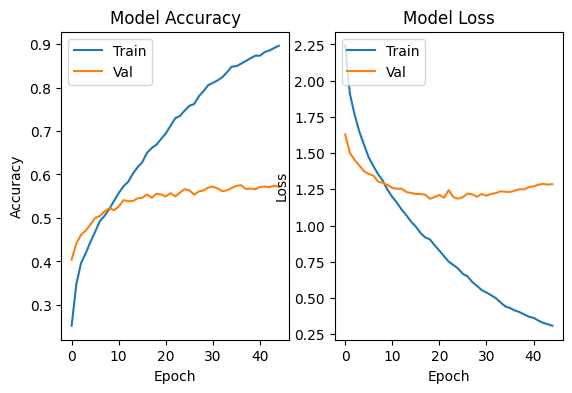

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training & validation accuracy values
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

In [ ]:
test_generator = ImageDataGenerator()

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

NameError: name 'test_generator' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()
